In [1]:
import keras
from keras import layers
from keras import backend as k

import theano
import theano.tensor as T

import pandas as pd
import numpy as np

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
BTSettl = pd.read_csv('.\data\BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv')
train_x = np.array(BTSettl[['age_Myr', 'M/Ms']])
train_y = np.array(BTSettl[['Li', 'G', 'G_BP', 'G_RP', 'J', 'H', 'K', 'g_p1', 'r_p1', 'i_p1', 'y_p1', 'z_p1']])

In [3]:
inputs = layers.Input(shape = (2,))
dense = layers.Dense(32, activation="relu")(inputs)
dropout = layers.Dropout(0.2)(dense)
dense = layers.Dense(64, activation="relu")(dropout)
outputs = layers.Dense(12)(dense)

callback = keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 1000, mode = 'min', restore_best_weights = True)

In [48]:
def custom_loss(y_true, y_pred): 
    return T.mean(T.square(y_true - y_pred))

class TheanoModel(keras.Model):  
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)   
           
    def train_step(self, data):
        x, y = data
        with theano.gradient.zero_grad():
            with theano.gradient.disconnected_grad(y):
                y_pred = self(x, training=True)
                loss = custom_loss(y, y_pred)
                gradients = theano.grad(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y, y_pred)
        
        return {'loss': loss, 'gradients': gradients, **{m.name: m.result() for m in self.metrics}}

In [50]:
theano_model = TheanoModel(inputs, outputs)

In [51]:
theano_model.compile(optimizer='adam', loss = custom_loss, metrics=['accuracy'])

In [52]:
history = theano_model.fit(train_x, train_y, epochs=5)

Epoch 1/5
838/838 [==============================] - 0s 84us/step - loss: 17.8695 - accuracy: 0.5370
Epoch 2/5
838/838 [==============================] - 0s 61us/step - loss: 12.1204 - accuracy: 0.5501
Epoch 3/5
838/838 [==============================] - 0s 97us/step - loss: 9.8325 - accuracy: 0.7100
Epoch 4/5
838/838 [==============================] - 0s 93us/step - loss: 9.9326 - accuracy: 0.6838
Epoch 5/5
838/838 [==============================] - 0s 144us/step - loss: 9.0217 - accuracy: 0.6337


In [53]:
history.history['gradients']

KeyError: 'gradients'

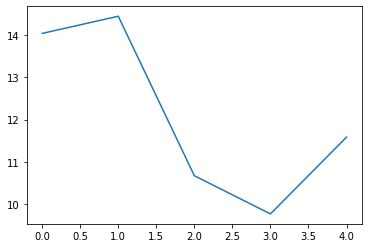

In [47]:
y = history.history['loss']
x = range(len(y))

import matplotlib.pyplot as plt

plt.plot(x, y)